In [252]:
#import libraries
from scipy import stats
import uproot
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression


231 74 101 188


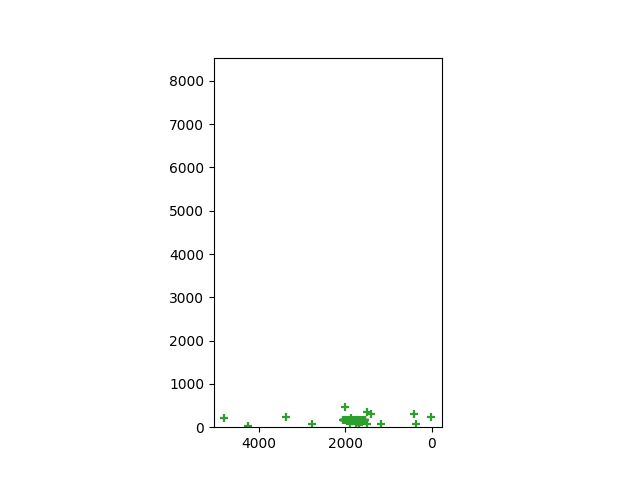

In [253]:

#Creating the noise file 
def open_noise(filename) :
    noise0=uproot.open(filename)
    noise1=noise0['pixTree']
    noise=pd.DataFrame(noise1['fData'].array(library="np"))
    noise=noise[noise.duplicated(subset=['row','col'])==True]
    noise.drop_duplicates(subset=['row','col'],inplace=True)
    X_noise=np.array(noise.col+((noise.chipId-4)*1024))
    Y_noise=np.array(noise.row)
    return X_noise,Y_noise

#put in the Noise data
Noise1=open_noise('../Noise1')
Noise2=open_noise('../Noise2')
Noise3=open_noise('../Noise3')
Noise4=open_noise('../Noise4')


,boardIndex,dataReceiver,deviceType,deviceId,chipId,row,col,bunchNum,trgNum,trgTime
0,0,3,4,162,8,190,4828,120,0,1115781244696474160
1,0,6,4,162,4,317,154,120,0,1115781244696474160
2,0,7,4,162,6,178,2138,120,0,1115781244696474160
3,0,8,4,162,5,172,1313,120,0,1115781244696474160
4,0,6,4,162,4,317,154,182,1,1115792153913406000
...,...,...,...,...,...,...,...,...,...,...
481064,0,3,4,162,8,173,4825,112,75398,56227501561426480
481065,0,3,4,162,8,195,4807,74,75399,56234979099488816
481066,0,3,4,162,8,195,4806,74,75399,56234979099488816
481067,0,3,4,162,8,196,4806,74,75399,56234979099488816


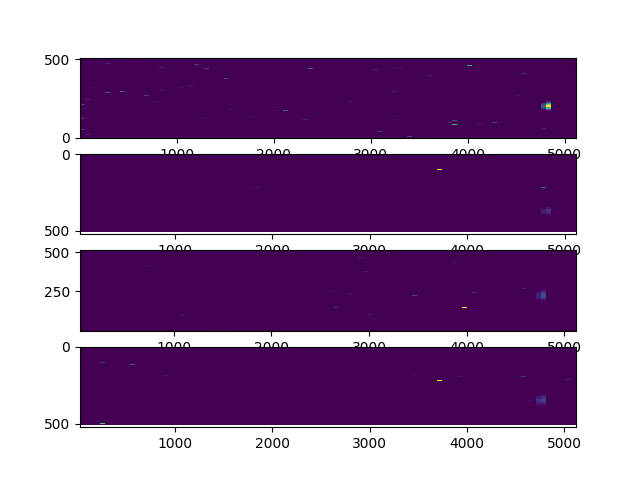

In [284]:
#open the root file and getting the tree (the root file are multinoiseScan_Date_Hour_RUNXX-B0-ladderX.root)
def open_file (filename):
    file=uproot.open(filename)

    file1=file['pixTree']
    Data=file1['fData'].array(library="np")
    data=pd.DataFrame(Data)
    data.col=((data.chipId-4)*1024)+data.col
    return data

data1=open_file("../Data1")
data2=open_file("../Data2")
data3=open_file("../Data3")
data4=open_file("../Data4")
fig, axes = plt.subplots(4)

display(data1)  #show the table with the different entries
axes[0].hist2d(data1.col,data1.row,bins=100,density=True)
axes[1].hist2d(data2.col,data2.row,bins=100,density=True)
axes[2].hist2d(data3.col,data3.row,bins=100,density=True)
axes[3].hist2d(data4.col,data4.row,bins=100,density=True)
axes[1].set_ylim(524,0)
axes[3].set_ylim(524,0)


In [285]:

#remove noise 
def remove_noise (noise,data) :
        n_0=data[data.col.isin(noise[0]) & data.row.isin(noise[1])].index
        if len(n_0)>0:
            data.drop(index=n_0,inplace=True)
        return data 


data1_filtered=remove_noise(Noise1,data1)
data2_filtered=remove_noise(Noise2,data2)
data3_filtered=remove_noise(Noise3,data3)
data4_filtered=remove_noise(Noise4,data4)


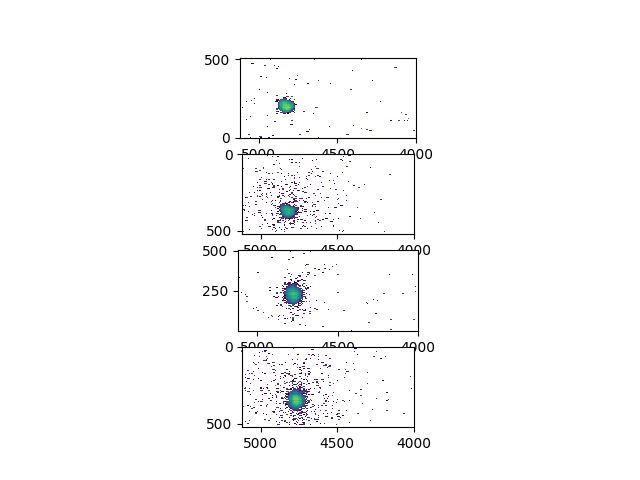

In [286]:

#Displaying the filtered data (Monitoring the experiment)
fig, axes = plt.subplots(4)
axes[0].hist2d(data1_filtered.col,data1_filtered.row,bins=[600,300],norm='symlog',cmin=1)
axes[1].hist2d(data2_filtered.col,data2_filtered.row,bins=[600,300],norm='symlog',cmin=1)
axes[2].hist2d(data3_filtered.col,data3_filtered.row,bins=[600,300],norm='symlog',cmin=1)
axes[3].hist2d(data4_filtered.col,data4_filtered.row,bins=[600,300],norm='symlog',cmin=1)
axes[0].axis('scaled')
axes[1].axis('scaled')
axes[2].axis('scaled')
axes[3].axis('scaled')
axes[0].set_xlim(5*1024,4000)
axes[1].set_xlim(5*1024,4000)
axes[1].set_ylim(524,0)
axes[2].set_xlim(5*1024,4000)
axes[3].set_xlim(5*1024,4000)
axes[3].set_ylim(524,0)
plt.show()

(5120.0, 4000.0)

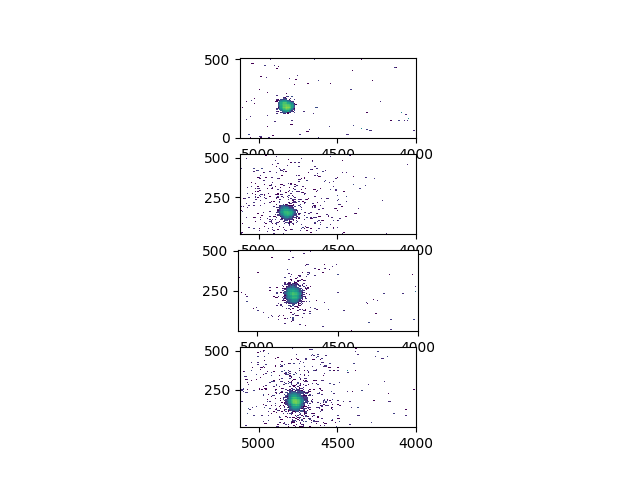

In [287]:
def flip_data_row (data) :
    data.row=524-data.row
    return data

flip_data_row(data2_filtered)
flip_data_row(data4_filtered)

#flipping the data from the even plane in y 

In [ ]:
# First alignement of the telescope 
def track (Pos_1,Pos_2,z) :
    x=((z-Pos_1[2])/(Pos_2[2]-Pos_1[2]))+Pos_1[0]
    y=((z-Pos_1[2])/(Pos_2[2]-Pos_1[2]))+Pos_1[1]
    return [x,y]


def alignement_telescope (DATA,Z) : 
    for i in range (len(DATA)) :
        for j in range (len(DATA)-1,i,-1) :
            for k in range (len(DATA)) :
                if k!=j and k!=i :
                    print(i,j,k)
                    print(Z[j]-Z[i])
                    Moved=track([np.mean(DATA[i].col),np.mean(DATA[i].row),Z[i]],[np.mean(DATA[j].col),np.mean(DATA[j].row),Z[j]],Z[k])
                    print(Moved[0],Moved[1])
                    print(np.mean(DATA[k].col)-Moved[0],np.mean(DATA[k].row)-Moved[1])
                    DATA[k].row=DATA[k].row+(Moved[1]-np.mean(DATA[k].row))
                    DATA[k].col=DATA[k].col+(Moved[0]-np.mean(DATA[k].col))


    return DATA


Z=[0,10.6,145,155.6]
DATA =[data1_filtered[data1_filtered.chipId==8],data2_filtered[data2_filtered.chipId==8],data3_filtered[data3_filtered.chipId==8],data4_filtered[data4_filtered.chipId==8]] #restriction to the useful chip
DATA1=alignement_telescope(DATA,Z) 


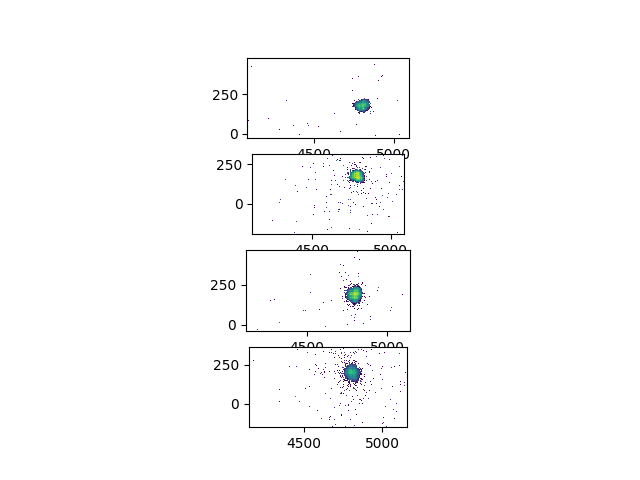

In [288]:
#Displaying the data aligned

fig, axes = plt.subplots(4)
axes[0].hist2d(DATA1[0].col,DATA1[0].row,bins=[600,300],norm='symlog',cmin=1)
axes[1].hist2d(DATA1[1].col,DATA1[1].row,bins=[600,300],norm='symlog',cmin=1)
axes[2].hist2d(DATA1[2].col,DATA1[2].row,bins=[600,300],norm='symlog',cmin=1)
axes[3].hist2d(DATA1[3].col,DATA1[3].row,bins=[600,300],norm='symlog',cmin=1)

axes[0].axis('scaled')
axes[1].axis('scaled')
axes[2].axis('scaled')
axes[3].axis('scaled')


plt.show()

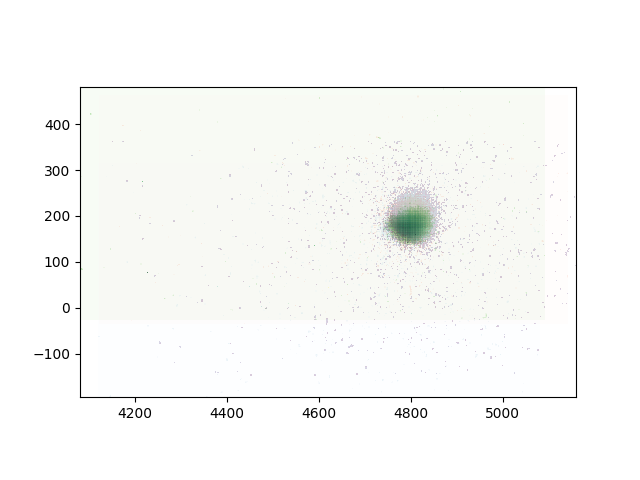

In [293]:
#Plotting superposed
fig, axes = plt.subplots()
plt.hist2d(DATA1[0].col,DATA1[0].row,bins=[600,300],norm='symlog',cmap='Greens')
plt.hist2d(DATA1[1].col,DATA1[1].row,bins=[600,300],norm='symlog',cmap='Blues',alpha=0.2)
plt.hist2d(DATA1[2].col,DATA1[2].row,bins=[600,300],norm='symlog',cmap='Reds',alpha=0.2)
plt.hist2d(DATA1[3].col,DATA1[3].row,bins=[600,300],norm='symlog',cmap='viridis',alpha=0.2,cmin=1)
plt.axis('scaled')
plt.show()

In [294]:
#Clustering with Agglomerative Clustering

def Clustering (data) :
    n=0
    Cluster=[]
    L=[]
    for i in range(max(data.trgNum)+1) :
        if data[data.trgNum==i].empty ==False :
            if (i in L) ==False :
                L.append(i)
                data_trgNum= data[data.trgNum==i] #useles if it's order there is a better way to do it
                if len(data_trgNum)!=1 :
                    X=data_trgNum[['row','col']].to_numpy()
                    clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=2,metric='euclidean').fit(X)
                    labels = clustering.labels_ 
                    for i in labels :
                        Cluster.append(i+n)
                    n=max(labels)+1+n
                else :
                    Cluster.append(n)
                    n+=1
    return Cluster

Cluster1=Clustering(DATA1[0])
Cluster2=Clustering(DATA1[1])
Cluster3=Clustering(DATA1[2])
Cluster4=Clustering(DATA1[3])


In [295]:
#Setting the clusters to the right data

data1_clusterized = DATA1[0]
data1_clusterized['cluster']=Cluster1
data2_clusterized = DATA1[1]
data2_clusterized['cluster']=Cluster2
data3_clusterized = DATA1[2]
data3_clusterized['cluster']=Cluster3
data4_clusterized = DATA1[3]
data4_clusterized['cluster']=Cluster4


In [296]:
#computing barycenter

def reduce_by_barycenter (data) :
    data['Xbar'] = 0
    data['Ybar'] = 0
    for i in range (1,data.cluster.max()+1) :
        data.loc[data['cluster']==i,'Xbar']=data[data['cluster']==i].col.mean()
        data.loc[data['cluster']==i,'Ybar']=data[data['cluster']==i].row.mean()
    B=data.drop_duplicates(subset=['Xbar','Ybar','cluster'],keep='first',inplace=False)
    return B


data1_reduced=reduce_by_barycenter (data1_clusterized)
data2_reduced=reduce_by_barycenter (data2_clusterized)
data3_reduced=reduce_by_barycenter (data3_clusterized)
data4_reduced=reduce_by_barycenter (data4_clusterized)



In [297]:
#fit the data 
def chi2 (xexp,xfit):
    chi2 =0 
    for i in range (len(xexp)):
        chi2+=((xexp[i]-xfit[i])**2)/xexp[i]
    return chi2

def tracking (X,Y,Z0) :
    model_X = LinearRegression()
    model_Y= LinearRegression()
    Z0=np.array(Z0)
    model_X.fit(Z0.reshape(-1,1),X)
    model_Y.fit(Z0.reshape(-1,1),Y)
    X_fit=model_X.predict(np.arange(0,160).reshape((-1, 1)))
    Y_fit=model_Y.predict((np.arange(0,160).reshape((-1, 1))))
    r_sq_X = model_X.score(Z0.reshape(-1,1),X)
    r_sq_Y=model_Y.score(Z0.reshape(-1,1),Y)
    chi2_x=chi2(X,[X_fit[0],X_fit[11],X_fit[146],X_fit[156]])
    chi2_y=chi2(Y,[Y_fit[0],Y_fit[11],Y_fit[146],Y_fit[156]])
    return ([X_fit,Y_fit],[r_sq_X,r_sq_Y],[chi2_x,chi2_y])

def distance_from_fit (xexp,xfit):
    chi2 =0 
    for i in range (len(xexp)):
        chi2+=((xexp[i]-xfit[i])**2)/4
    return np.sqrt(chi2)


In [309]:

#Alignement from the tracking 

def precise_alignement (DATA,Z0) :
    Distances_X=[[],[],[],[]]
    Distances_Y=[[],[],[],[]]
    for i in range(max(data1.trgNum)) :
        if (len(DATA[0][DATA[0].trgNum==i]) ==1) and (len(DATA[1][DATA[1].trgNum==i])==1) and (len(DATA[2][DATA[2].trgNum==i]) ==1) and (len(DATA[3][DATA[3].trgNum==i]) ==1):
            for k in range(4):
                X=[]
                Y=[]
                Z=[]
                for j in range (4):
                    if j!=k:
                        X.append(DATA[j].at[DATA[j][DATA[j].trgNum==i].index[0],'col'])
                        Y.append(DATA[j].at[DATA[j][DATA[j].trgNum==i].index[0],'row'])
                        Z.append(int(Z0[j]))
                L=tracking (X,Y,Z)
                distance_x=L[0][0][int(Z0[k])]-DATA[k].at[DATA[k][DATA[k].trgNum==i].index[0],'col']
                distance_y=L[0][1][int(Z0[k])]-DATA[k].at[DATA[k][DATA[k].trgNum==i].index[0],'row']
                Distances_X[k].append(distance_x)
                Distances_Y[k].append(distance_y)
    return Distances_X,Distances_Y



DATA=[data1_reduced,data2_reduced,data3_reduced,data4_reduced]
Z=[0,10.6,145,155.6]
Distances=precise_alignement(DATA,Z)
print('x',np.mean(Distances[0][0]),np.mean(Distances[0][1]),np.mean(Distances[0][2]),np.mean(Distances[0][3]),'Y',np.mean(Distances[1][0]),np.mean(Distances[1][1]),np.mean(Distances[1][2]),np.mean(Distances[1][3]))

x -16.598408092427633 14.880360317090565 8.46033588443628 -10.182594029528452 Y -2.313751079315755 1.5539407112718386 8.72399760575325 -9.479105718998985


In [310]:
#moving from the correction that we had previously
def move (data,x,y):
    data.row=data.row+x
    data.col=data.col+y

for i in range(4) :
    move(DATA[i],np.mean(Distances[0][i]),np.mean(Distances[1][i]))



/var/folders/yd/bspn4nk108s_wp9xx41068k5sng6tm/T/ipykernel_21817/2655116769.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yd/bspn4nk108s_wp9xx41068k5sng6tm/T/ipykernel_21817/2655116769.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [233]:
#computing the mean resolution (Distances from the track in X and in Y)

def mean_resolution (data1,data2,data3,data4,Z) :
    Resolutions_X =[]
    Resolutions_Y =[]

    Tracking=[]
    for i in range(max(data1.trgNum)) :
        if (len(data1[data1.trgNum==i]) ==1) and (len(data4[data4.trgNum==i])==1) and (len(data2[data2.trgNum==i]) ==1) and (len(data3[data3.trgNum==i]) ==1):
            X=[data1.at[data1[data1.trgNum==i].index[0],'col'],data2.at[data2[data2.trgNum==i].index[0],'col'],data3.at[data3[data3.trgNum==i].index[0],'col'],data4.at[data4[data4.trgNum==i].index[0],'col']]
            Y=[data1.at[data1[data1.trgNum==i].index[0],'row'],data2.at[data2[data2.trgNum==i].index[0],'row'],data3.at[data3[data3.trgNum==i].index[0],'row'],data4.at[data4[data4.trgNum==i].index[0],'row']]
            L=tracking (X,Y,Z)
            Resolutions_X.append(distance_from_fit(X,[L[0][0][0],L[0][0][11],L[0][0][146],L[0][0][156]]))
            Resolutions_Y.append(distance_from_fit(Y,[L[0][1][0],L[0][1][11],L[0][1][146],L[0][1][156]]))
            Tracking.append([L,i])
            if (distance_from_fit(X,[L[0][0][0],L[0][0][11],L[0][0][146],L[0][0][156]]))>150 :
                print(int(i))

    return(Resolutions_X,Resolutions_Y)
Resolutions=mean_resolution(DATA[0],DATA[1],DATA[2],DATA[3],Z)

In [ ]:

Resolutions_cut=[]
# for i in range (len(Resolutions[1])):
#     if Resolutions[0][i]<50 :
#         Resolutions_cut.append(Resolutions[0][i])
fig,axes=plt.subplots()
display(Resolutions[0])
print(np.mean(Resolutions[0]),np.mean(Resolutions[1]))
print(np.percentile(Resolutions[0], 75),np.percentile(Resolutions[1],75))

axes.hist(Resolutions[0],bins=30)
axes.hist(Resolutions[1],bins=50)
plt.show()
